In [1]:
import megatron as me
from scipy.sparse import load_npz

/Users/huidong/anaconda3/envs/env_megatron/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


In [2]:
me.__version__

'0.1a'

In [3]:
workdir = 'result_larry_subset'
me.settings.set_workdir(workdir)

Saving results in: result_larry_subset


In [4]:
me.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[5,5],
                              rc={'image.cmap': 'viridis'})

In [5]:
adata = me.read_h5ad('rnaseq_weinreb20_invitro_subset.h5ad')
adata

AnnData object with n_obs × n_vars = 3221 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    obsm: 'X_SPRING'

In [6]:
mat_clones = load_npz('clones_weinreb20_invitro_subset.npz')
mat_clones

<3221x5864 sparse matrix of type '<class 'numpy.int64'>'
	with 3221 stored elements in Compressed Sparse Column format>

In [7]:
me.pp.add_clones(adata, 
                 mat=mat_clones)
adata

AnnData object with n_obs × n_vars = 3221 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    uns: 'clone'
    obsm: 'X_SPRING', 'X_clone'

In [8]:
me.pp.filter_clones(adata,min_cells=1)
adata

Before filtering: 5864 clones
After filtering: 365 clones


AnnData object with n_obs × n_vars = 3221 × 25289
    obs: 'Time point', 'Population', 'Annotation', 'Well'
    uns: 'clone'
    obsm: 'X_SPRING', 'X_clone'

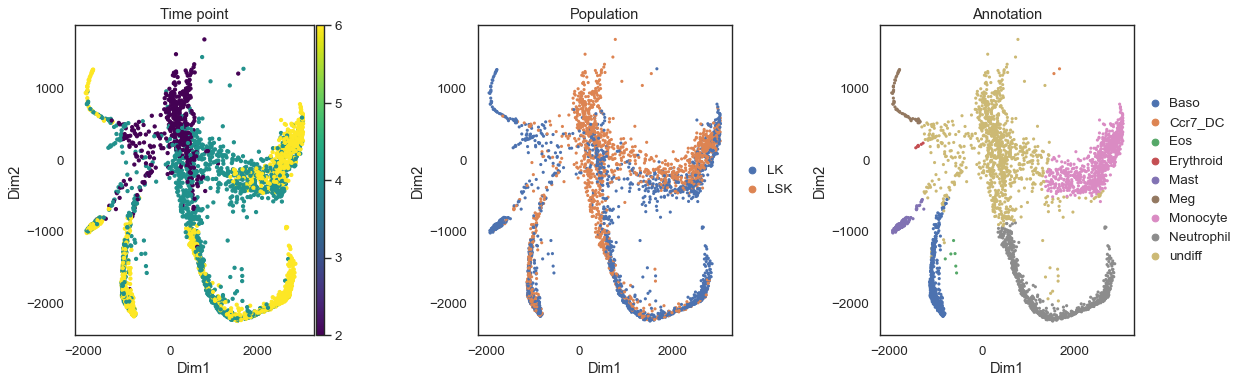

In [9]:
me.pl.scatter(adata, 
              color=['Time point','Population','Annotation'],
              drawing_order='random',
              obsm='X_SPRING')

In [10]:
me.tl.clone_distance(adata,
                     method='geodesic',
                     obsm='X_SPRING',
                     anno_time='Time point',
                     n_jobs=4)

Finished: 0.9081940531730652 mins


In [11]:
adata.uns['clone'].keys()

dict_keys(['anno', 'distance_geodesic', 'distance'])

In [12]:
me.tl.cluster_clones(adata,
                     n_clusters=6,
                     method='hierarchical')

In [13]:
adata.uns['clone']['anno'].head()

,hierarchical
50,6
82,5
105,3
111,6
134,4


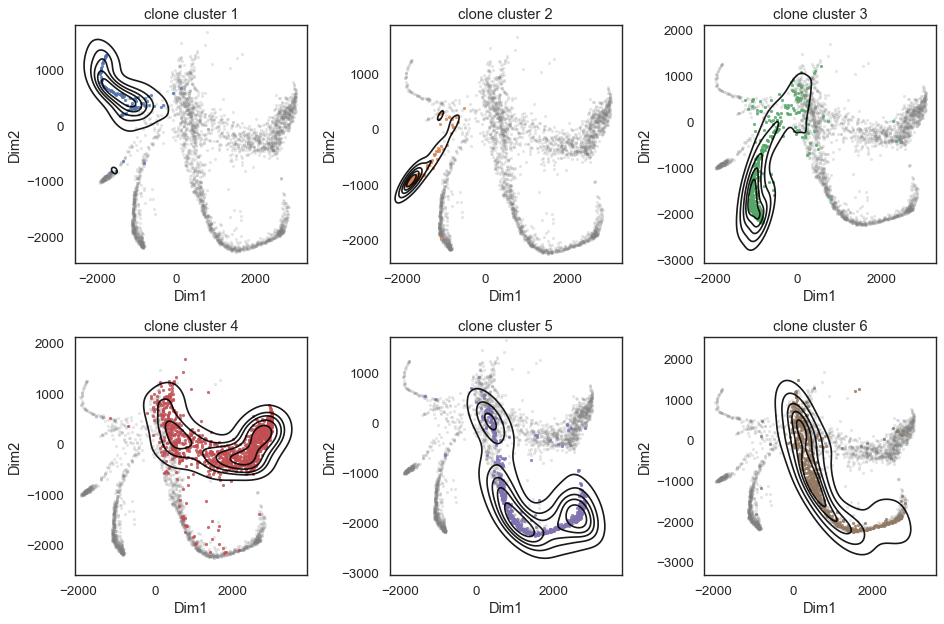

In [14]:
me.pl.clone_scatter(adata, group='hierarchical', obsm='X_SPRING',show_contour=True, 
                    levels=6, thresh=0.1)

In [16]:
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score

df_truth = pd.read_csv('clones_truth.tsv.gz',sep='\t',index_col=0)
all(df_truth.index.astype(str) == adata.uns['clone']['anno'].index)

True

In [18]:
adjusted_rand_score(df_truth['celltype'].tolist(),  adata.uns['clone']['anno']['hierarchical'].tolist())

0.8264594581709477